## **Executive Summary**

### **Key Findings**

In this notebook, I relied on a RandomForest model to determine my benchmark model. I utilized it to determine which features played the most significant role in inducing salary variance.


### **Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?**
- Country: Median salaries tended to be highest the countries of MX, PR, and US.
- Experience: Median salaries were highest for Executive, followed by Senior, Mid-level, and Entry-level
- Remote Ratio: Median Salaries were highest for pure on-site employees, whose salaries were only slightly higher than those of pure remote workers.

### **Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?**
Using the RandomForest model and only features pertaining to experience level, company location, and remote ratio revealed that the most important features that determined salary level was a company location in US or CA. A third feature, experience level, was of secondary significance.

### **Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? Finally, propose new features to make future salary predictions even more accurate future salary predictions even more accurate.**

After incorporating additional features of company size and employment type, the most influential features on data salaries were:
- job title containing word 'analyst'
- experience_level
- company location in US
- job title containing word 'data'
- remote_ratio

The insight that this information provides is that data salaries are strongly determined by position and location, specifically whether that location is the United States or not.

## 📖 **Background**
You work for an international HR consultancy helping companies attract and retain top talent in the competitive tech industry. As part of your services, you provide clients with insights into industry salary trends to ensure they remain competitive in hiring and compensation practices.

Your team wants to use a data-driven approach to analyse how various factors—such as job role, experience level, remote work, and company size—impact salaries globally. By understanding these trends, you can advise clients on offering competitive packages to attract the best talent.

In this competition, you’ll explore and visualise salary data from thousands of employees worldwide. f you're tackling the advanced level, you'll go a step further—building predictive models to uncover key salary drivers and providing insights on how to enhance future data collection.

## 💾 **Data**

The data comes from a survey hosted by an HR consultancy, available in `'salaries.csv'`.

#### Each row represents a single employee's salary record for a given year:
- **`work_year`** - The year the salary was paid.  
- **`experience_level`** - Employee experience level:  
  - **`EN`**: Entry-level / Junior  
  - **`MI`**: Mid-level / Intermediate  
  - **`SE`**: Senior / Expert  
  - **`EX`**: Executive / Director  
- **`employment_type`** - Employment type:  
  - **`PT`**: Part-time  
  - **`FT`**: Full-time  
  - **`CT`**: Contract  
  - **`FL`**: Freelance  
- **`job_title`** - The job title during the year.  
- **`salary`** - Gross salary paid (in local currency).  
- **`salary_currency`** - Salary currency (ISO 4217 code).  
- **`salary_in_usd`** - Salary converted to USD using average yearly FX rate.  
- **`employee_residence`** - Employee's primary country of residence (ISO 3166 code).  
- **`remote_ratio`** - Percentage of remote work:  
  - **`0`**: No remote work (<20%)  
  - **`50`**: Hybrid (50%)  
  - **`100`**: Fully remote (>80%)  
- **`company_location`** - Employer's main office location (ISO 3166 code).  
- **`company_size`** - Company size:  
  - **`S`**: Small (<50 employees)  
  - **`M`**: Medium (50–250 employees)  
  - **`L`**: Large (>250 employees)  

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Custom functions
import nb_helpers as nb

In [2]:
df = pd.read_csv('../data/salaries.csv')

df['job_title'] = df['job_title'].apply(lambda x: x.lower())
df['experience_level'] = df['experience_level'].apply(lambda x: x.lower())
df['employee_residence'] = df['employee_residence'].apply(lambda x: x.lower())
df['company_size'] = df['company_size'].apply(lambda x: x.lower())

df['company_location'] = nb.remap_company_location(df)

print(df.shape)

df.head()

(57194, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,mi,FT,developer,168276,USD,168276,us,0,US,m
1,2024,mi,FT,developer,112184,USD,112184,us,0,US,m
2,2024,en,FT,developer,180000,USD,180000,us,0,US,m
3,2024,en,FT,developer,133500,USD,133500,us,0,US,m
4,2024,en,FT,developer,122000,USD,122000,us,0,US,m


In [3]:
# useful containers
target = 'salary_in_usd'
salary_thereshold = df['salary_in_usd'].quantile(0.98)
models = []

## Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?

In [4]:
# Filter for Data Analysts, Data Scientists, and Machine Learning Engineers
roles_of_interest = ['data analyst', 'data scientist', 'machine learning engineer']
filtered_df = df[df['job_title'].isin(roles_of_interest)]


experience_map = {
    'se': 'senior',
    'mi': 'mid-level',
    'en': 'entry-level',
    'ex': 'executive'
}

# Task 1: Average salary by country, experience level, and remote ratio
salary_by_country = filtered_df.groupby('employee_residence')['salary_in_usd'].median().reset_index()
salary_by_country.columns = list(salary_by_country.columns[:1]) + ['median_salary']


count_by_country = filtered_df.groupby('employee_residence')['salary_in_usd'].count().reset_index()
count_by_country.columns = list(count_by_country.columns[:1]) + ['count_salary']

merge_cols = list(salary_by_country.columns[:1])

salary_df = pd.merge(salary_by_country, count_by_country, on = 'employee_residence').sort_values(by = "median_salary", ascending = False)
salary_threshold = salary_df['count_salary'].quantile(0.75)
salary_df = salary_df[salary_df['count_salary'] > salary_threshold].set_index('employee_residence')[['median_salary']]

<Figure size 1000x600 with 0 Axes>

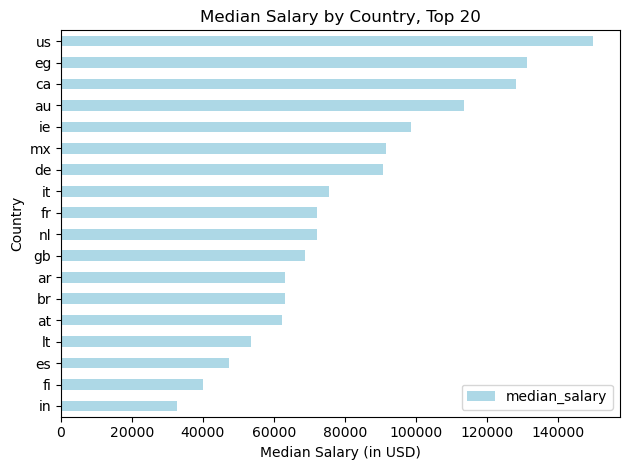

In [5]:
# Task 1: Visualize the results for salary impact analysis
top = 20

# Visualization for Salary by Country
plt.figure(figsize=(10, 6))
salary_df[:top][::-1].plot(kind='barh', color='lightblue')
plt.title(f'Median Salary by Country, Top {top}')
plt.xlabel('Median Salary (in USD)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

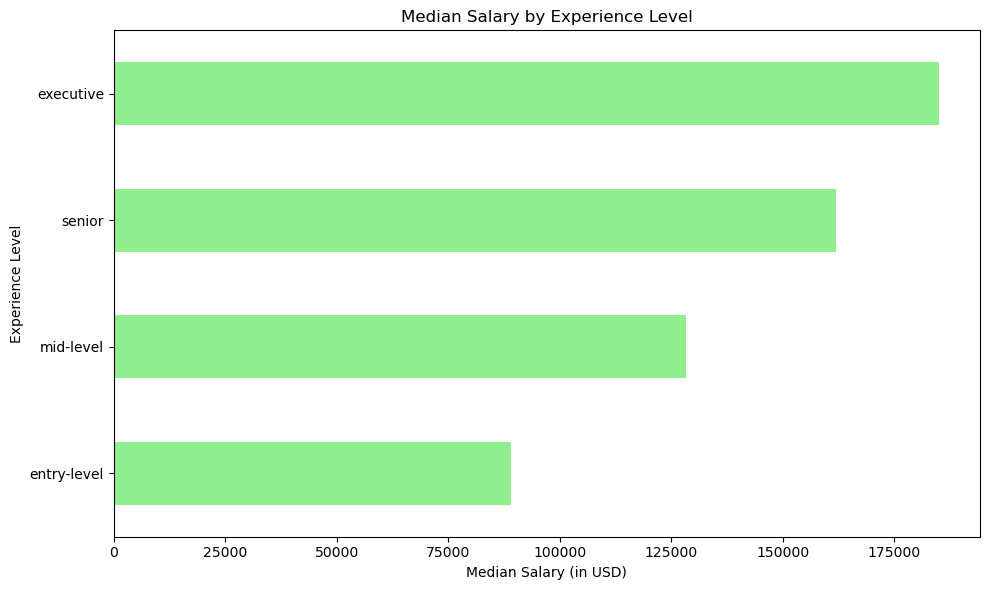

In [6]:
avg_salary_by_experience = filtered_df.groupby('experience_level')['salary_in_usd'].median().sort_values(ascending=False)
avg_salary_by_experience.index = [experience_map[role] for role in avg_salary_by_experience.index]

# Visualization for Average Salary by Experience Level
plt.figure(figsize=(10, 6))
avg_salary_by_experience[::-1].plot(kind='barh', color='lightgreen')
plt.title('Median Salary by Experience Level')
plt.xlabel('Median Salary (in USD)')
plt.ylabel('Experience Level')
plt.tight_layout()
plt.show()

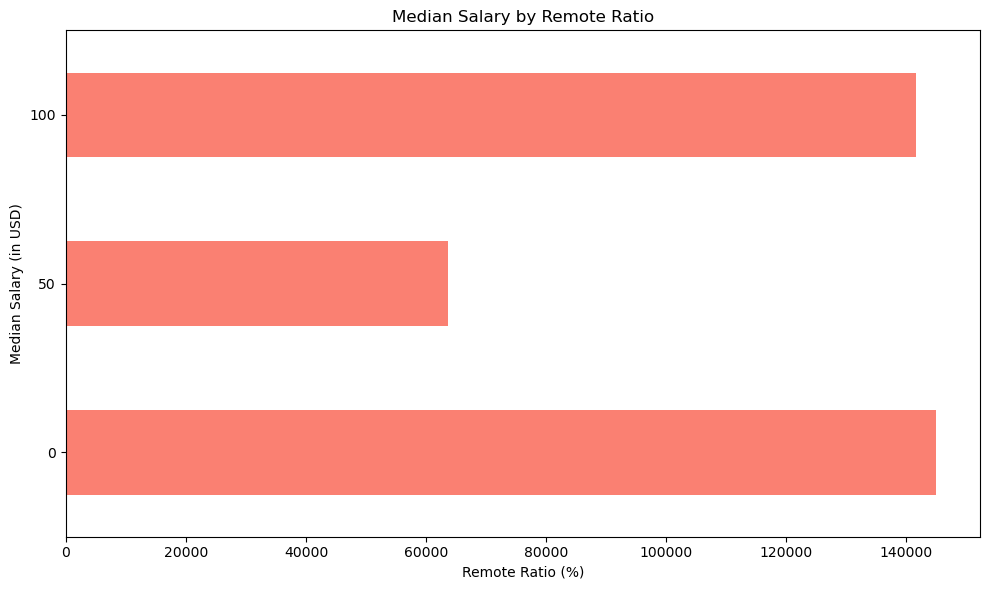

In [7]:
avg_salary_by_remote_ratio = filtered_df.groupby('remote_ratio')['salary_in_usd'].median()

# Visualization for Average Salary by Remote Ratio
plt.figure(figsize=(10, 6))
avg_salary_by_remote_ratio.plot(kind='barh', color='salmon')
plt.title('Median Salary by Remote Ratio')
plt.xlabel('Remote Ratio (%)')
plt.ylabel('Median Salary (in USD)')
plt.tight_layout()
plt.show()

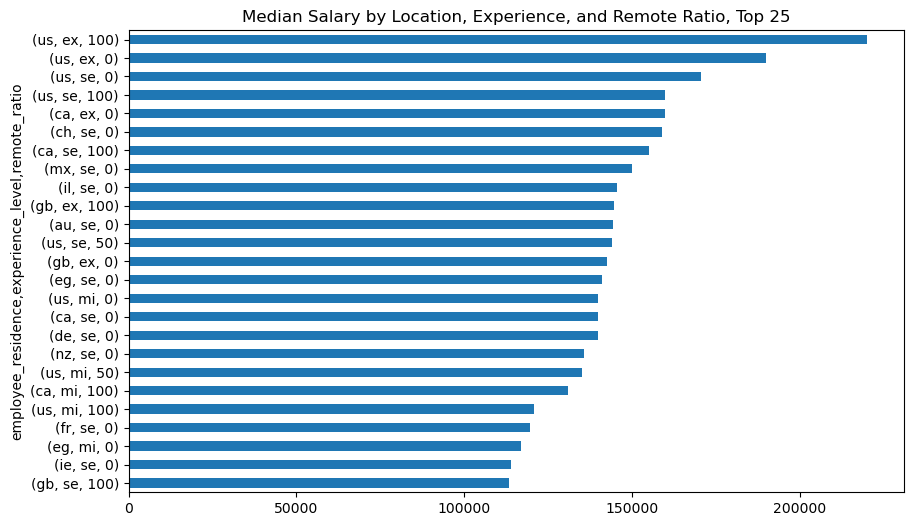

In [8]:
median_salaries = df.groupby(['employee_residence', 'experience_level', 'remote_ratio'])['salary_in_usd'].median().reset_index()
median_salaries.columns = list(median_salaries.columns[:3]) + ['median_salary']
count_salaries = df.groupby(['employee_residence', 'experience_level', 'remote_ratio'])['salary_in_usd'].count().reset_index()
count_salaries.columns = list(count_salaries.columns[:3]) + ['count_of_salary']

merge_cols = list(median_salaries.columns[:3])
salary_df = pd.merge(median_salaries, count_salaries, on = merge_cols).sort_values(by = 'median_salary', ascending = False)
salary_threshold = salary_df['count_of_salary'].quantile(0.75)
salary_df = salary_df[salary_df['count_of_salary'] > salary_threshold]
salary_df


top = 25
plt.figure(figsize=(10, 6))
salary_df.set_index(['employee_residence', 'experience_level', 'remote_ratio'])['median_salary'][:top][::-1].plot(kind = "barh")
plt.title(f'Median Salary by Location, Experience, and Remote Ratio, Top {top}')
plt.show()

## Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?

### Model 1: Baseline

In [9]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc']
df1 = nb.ohe_features_and_concat(df1, feature_list)

df1 = df1.drop(['work_year','salary_currency','salary','employee_residence','company_size', 'job', 'type'], axis = 1)

In [10]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,company_loc_PL,company_loc_PT,company_loc_RU,company_loc_SE,company_loc_SG,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_US,company_loc_ZA
35762,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39437,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19785,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
33555,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
28733,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


model 1 (baseline) RMSE score: 66109.99




<Figure size 1000x600 with 0 Axes>

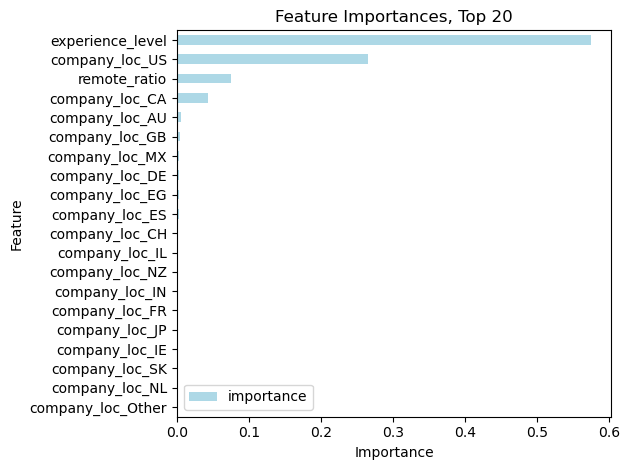

In [11]:
model_name = 'model 1 (baseline)'

result = nb.train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
df_feat = nb.visualize_feature_importances(X_train, result, 20)
models.append(result)

## Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? 

### Model 2: Adding company size and employment type

In [12]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc','company_size','type']
df1 = nb.ohe_features_and_concat(df1, feature_list)

# Drop columns
df1.drop(['salary','salary_currency','employee_residence', 'work_year', 'job'], axis = 1, inplace = True)

In [13]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_US,company_loc_ZA,company_size_m,company_size_s,type_FL,type_FT,type_PT
35762,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
39437,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
19785,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
33555,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
28733,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


model 2 RMSE score: 66085.67




<Figure size 1000x600 with 0 Axes>

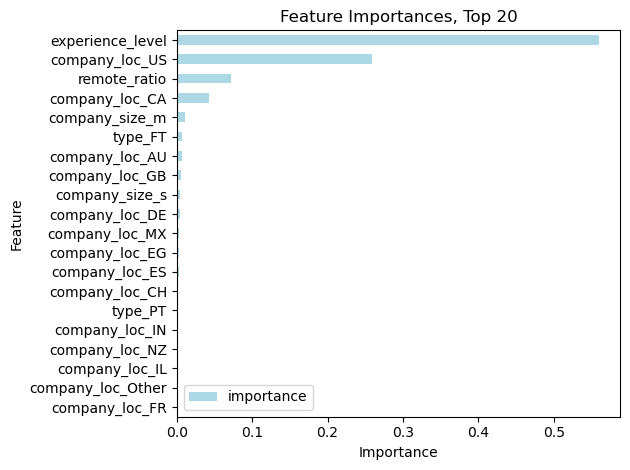

In [14]:
model_name = 'model 2'

result = nb.train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
df_feat = nb.visualize_feature_importances(X_train, result, 20)
models.append(result)

## Propose new features to make future salary predictions even more accurate future salary predictions even more accurate.

### Model 3: Add job title information

In [15]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc','company_size','type']
df1 = nb.ohe_features_and_concat(df1, feature_list)

# Job Title token
vectorizer = CountVectorizer(lowercase=True, binary=True, max_features = 50, )
job_title_counts = vectorizer.fit_transform(df1['job'])
columns = vectorizer.get_feature_names_out()
columns = [f'title_{c}' for c in columns]
job_title_counts_df = pd.DataFrame(job_title_counts.toarray(), columns=columns)
df1 = pd.concat([df1, job_title_counts_df], axis=1)

# Drop columns
df1.drop(['salary','salary_currency','employee_residence', 'work_year', 'job'], axis = 1, inplace = True)

In [16]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop(target, axis = 1)
y = df1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,title_researcher,title_scientist,title_site,title_software,title_solutions,title_specialist,title_stack,title_systems,title_vision,title_visualization
35762,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
39437,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
19785,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
33555,3,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
28733,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


model 3 RMSE score: 60457.85




<Figure size 1000x600 with 0 Axes>

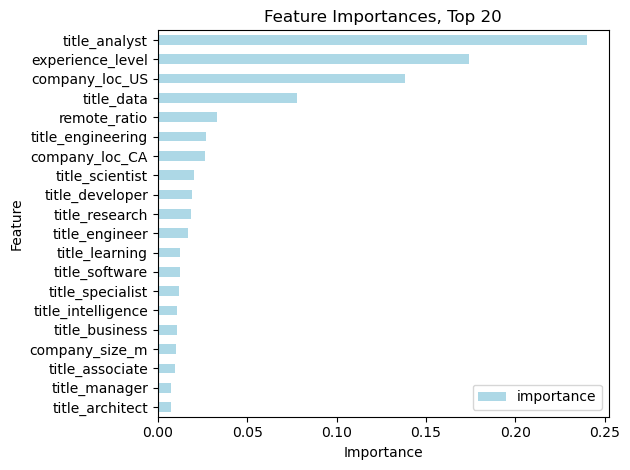

In [17]:
model_name = 'model 3'

result = nb.train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
df_feat = nb.visualize_feature_importances(X_train, result, 20)
models.append(result)

### Explore Linear Model

In [94]:
df1 = df.copy()
df1 = df1.rename(columns = {'company_location': 'company_loc', 'job_title': 'job', 'employment_type': 'type'})

# LabelEncoder: experience
le = LabelEncoder()
df1['experience_level'] = le.fit_transform(df1['experience_level'])

# OHE Encoding
feature_list = ['company_loc']
df1 = nb.ohe_features_and_concat(df1, feature_list)

df1['log_salary'] = np.log1p(df1['salary_in_usd'])

df1 = df1.drop(['salary_in_usd','work_year','salary_currency','salary','employee_residence','company_size', 'job', 'type'], axis = 1)
df1.head()

,experience_level,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,company_loc_PT,company_loc_RU,company_loc_SE,company_loc_SG,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_US,company_loc_ZA,log_salary
0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.033367
1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.627905
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.100718
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.801864
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.711785


#### Assess linear relationship

<AxesSubplot:>

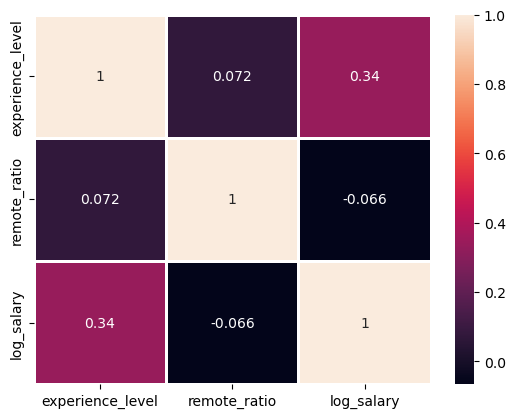

In [95]:
sns.heatmap(df1[['experience_level', 'remote_ratio','log_salary']].corr(), annot=True, linewidths=2)

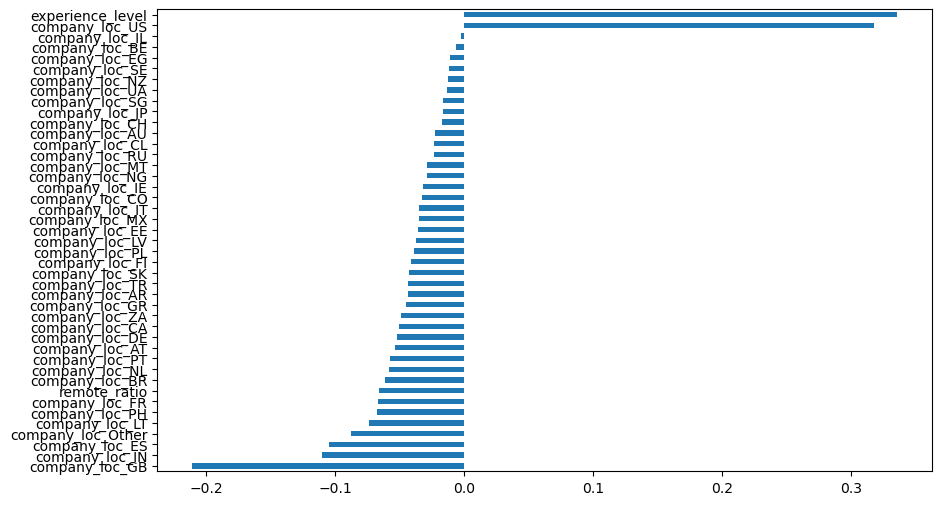

In [96]:
plt.figure(figsize=(10, 6))

df1.corr()['log_salary'].sort_values(ascending = False)[1:][::-1].plot(kind = 'barh')
plt.show()

#### Assess multicollinearity

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = df1.drop('log_salary', axis = 1)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

feature_to_remove = []
for i, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['Feature']} => {row['VIF']}")
        feature_to_remove.append(row['Feature'])

print(f"There are {len(feature_to_remove)} to remove")

experience_level => 8.04447129292455
company_loc_US => 7.572258849671367
There are 2 to remove


In [98]:
df1['experience_level_x_loc_US'] = df1['experience_level'] * df1['company_loc_US']
df1 = df1.drop(['experience_level', 'company_loc_US'], axis = 1)

In [99]:
features = df1.drop('log_salary', axis = 1)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

feature_to_remove = []
for i, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['Feature']} => {row['VIF']}")
        feature_to_remove.append(row['Feature'])

print(f"There are {len(feature_to_remove)} to remove")

There are 0 to remove


### Fitting model

In [100]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [101]:
# Prepare the features (X) and target (y) for training the model
X = df1.drop('log_salary', axis = 1)
y = df1['log_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_train.head()

,const,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,...,company_loc_PL,company_loc_PT,company_loc_RU,company_loc_SE,company_loc_SG,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_ZA,experience_level_x_loc_US
35762,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
39437,1.0,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
19785,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
33555,1.0,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
28733,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [102]:
model = sm.OLS(y_train, X_train).fit()

In [103]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     310.1
Date:                Thu, 06 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:15:40   Log-Likelihood:                -24866.
No. Observations:               45755   AIC:                         4.982e+04
Df Residuals:                   45712   BIC:                         5.019e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [104]:
residuals = model.resid

C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


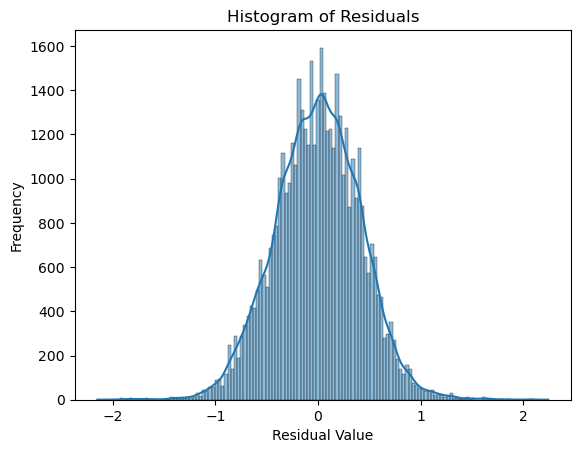

In [105]:
# Plot histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


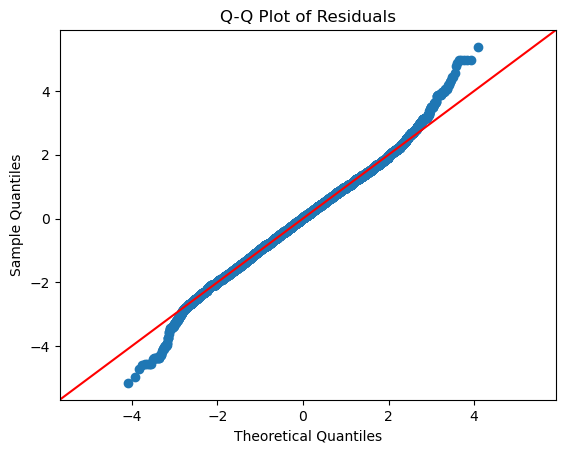

In [106]:
# Q-Q plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()


In [107]:
import statsmodels.api as sm

_, pval, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, X_train)
print(f"Breusch-Pagan test p-value: {pval}")


Breusch-Pagan test p-value: 3.2134199558909086e-308


                            WLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.235
Model:                            WLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     335.2
Date:                Thu, 06 Mar 2025   Prob (F-statistic):               0.00
Time:                        15:15:43   Log-Likelihood:                -25100.
No. Observations:               45755   AIC:                         5.029e+04
Df Residuals:                   45712   BIC:                         5.066e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

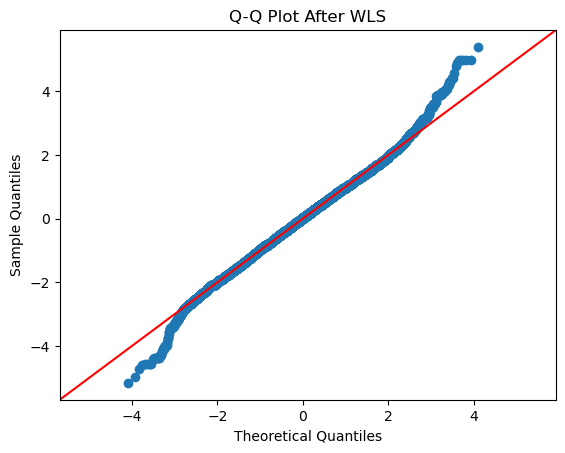

In [108]:
# Compute weights: Inverse of squared fitted values
weights = 1 / (model.fittedvalues ** 2)

# Fit Weighted Least Squares model
model_wls = sm.WLS(y_train, X_train, weights=weights).fit()

# Print summary
print(model_wls.summary())

# Re-check residuals
sm.qqplot(model_wls.resid, line='45', fit=True)
plt.title("Q-Q Plot After WLS")
plt.show()


                    Robust linear Model Regression Results                    
Dep. Variable:             log_salary   No. Observations:                45755
Model:                            RLM   Df Residuals:                    45712
Method:                          IRLS   Df Model:                           42
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 06 Mar 2025                                         
Time:                        15:15:52                                         
No. Iterations:                    33                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

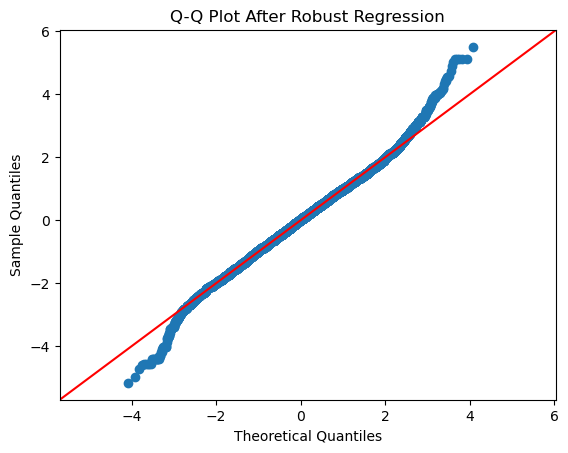

In [109]:
from statsmodels.robust.robust_linear_model import RLM

# Fit robust regression
model_robust = RLM(y_train, X_train).fit()

# Print summary
print(model_robust.summary())

# Re-check residuals
sm.qqplot(model_robust.resid, line='45', fit=True)
plt.title("Q-Q Plot After Robust Regression")
plt.show()


#### Checking residual shape

C:\Users\Brett Lill\AppData\Roaming\Python\Python39\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


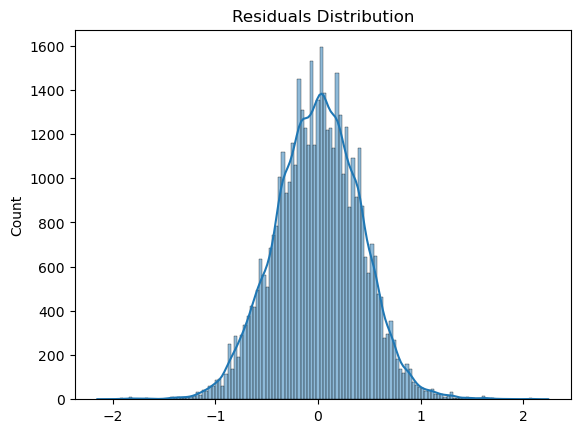

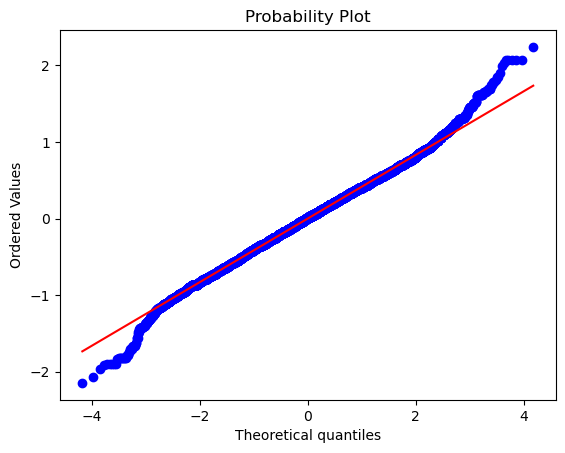

In [111]:
import scipy.stats as stats

# Compute residuals
y_pred = model.predict(X_train)
residuals = y_train - y_pred

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:             log_salary   No. Observations:                45755
Model:                            GLM   Df Residuals:                    45712
Model Family:                   Gamma   Df Model:                           42
Link Function:          inverse_power   Scale:                       0.0012455
Method:                          IRLS   Log-Likelihood:                -25126.
Date:                Thu, 06 Mar 2025   Deviance:                       57.066
Time:                        15:16:21   Pearson chi2:                     56.9
No. Iterations:                     8   Pseudo R-squ. (CS):             0.2518
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

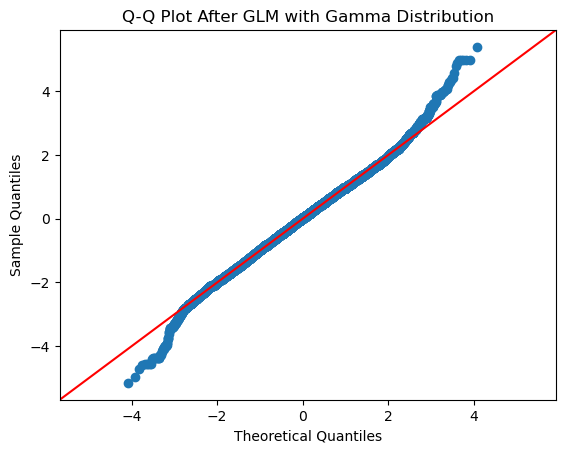

In [112]:

# Fit Generalized Linear Model with a Gamma family (better for skewed data)
model_glm = sm.GLM(y_train, X_train, family=sm.families.Gamma()).fit()

# Print summary
print(model_glm.summary())

# Re-check residuals
sm.qqplot(model_glm.resid_response, line='45', fit=True)
plt.title("Q-Q Plot After GLM with Gamma Distribution")
plt.show()


In [113]:
import statsmodels.formula.api as smf

,remote_ratio,company_loc_AR,company_loc_AT,company_loc_AU,company_loc_BE,company_loc_BR,company_loc_CA,company_loc_CH,company_loc_CL,company_loc_CO,...,company_loc_PT,company_loc_RU,company_loc_SE,company_loc_SG,company_loc_SK,company_loc_TR,company_loc_UA,company_loc_ZA,log_salary,experience_level_x_loc_US
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.033367,2.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.627905,2.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.100718,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.801864,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.711785,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57189,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.928781,3.0
57190,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.925042,2.0
57191,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.561725,0.0
57192,100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.512935,0.0


remote_ratio + company_loc_AR + company_loc_AT + company_loc_AU + company_loc_BE + company_loc_BR + company_loc_CA + company_loc_CH + company_loc_CL + company_loc_CO + company_loc_DE + company_loc_EE + company_loc_EG + company_loc_ES + company_loc_FI + company_loc_FR + company_loc_GB + company_loc_GR + company_loc_IE + company_loc_IL + company_loc_IN + company_loc_IT + company_loc_JP + company_loc_LT + company_loc_LV + company_loc_MT + company_loc_MX + company_loc_NG + company_loc_NL + company_loc_NZ + company_loc_Other + company_loc_PH + company_loc_PL + company_loc_PT + company_loc_RU + company_loc_SE + company_loc_SG + company_loc_SK + company_loc_TR + company_loc_UA + company_loc_ZA + experience_level_x_loc_US
                         QuantReg Regression Results                          
Dep. Variable:             log_salary   Pseudo R-squared:               0.1043
Model:                       QuantReg   Bandwidth:                     0.05216
Method:                 Least Squares  

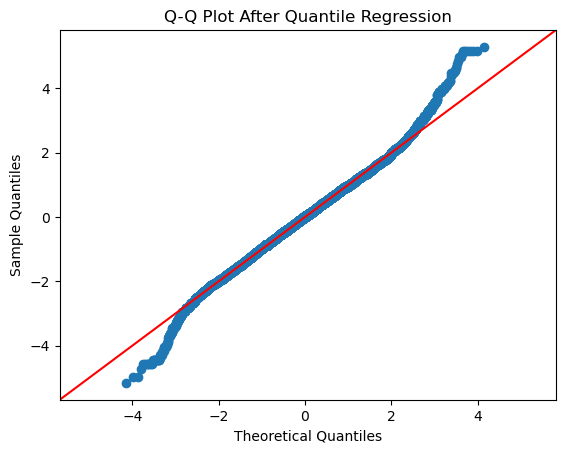

In [114]:

feature_str = " + ".join([f for f in df1.columns if f != 'log_salary'])
print(feature_str)

# Fit quantile regression (median)
model_qr = smf.quantreg(f'log_salary ~ {feature_str}', df1).fit(q=0.5)

# Print summary
print(model_qr.summary())

# Re-check residuals
sm.qqplot(model_qr.resid, line='45', fit=True)
plt.title("Q-Q Plot After Quantile Regression")
plt.show()


### Summary

In [18]:
model_df = pd.DataFrame(models).drop('model', axis = 1).sort_values(by='rmse')
best_model = model_df.iloc[0]
model_df

,name,n_features,rmse,best_features
2,model 3,98,60457.85,"[title_analyst, experience_level, company_loc_..."
1,model 2,48,66085.67,"[experience_level, company_loc_US, remote_ratio]"
0,model 1 (baseline),43,66109.99,"[experience_level, company_loc_US, remote_ratio]"


In [19]:
print(f"The best model is {best_model['name']}. It was trained on {best_model['n_features']} features and achieved a root mean squared error score of {best_model['rmse'].round(0)}. \n\nThe model's most influential features were: ")
for feature in best_model['best_features']:
    print(f"- {feature}")

The best model is model 3. It was trained on 98 features and achieved a root mean squared error score of 60458.0. 

The model's most influential features were: 
- title_analyst
- experience_level
- company_loc_US
- title_data
- remote_ratio
